In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [2]:
(x_train_full, y_train_full), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
x_train_full = x_train_full.astype(np.float32) / 255
x_test = x_test.astype(np.float32) / 255
x_train, x_valid = x_train_full[:-5000], x_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [3]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))


def plot_image(image):
    plt.imshow(image, cmap='binary')
    plt.axis('off')
    
    
def show_reconstructions(model, images=x_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

In [4]:
np.random.seed(42)
tf.random.set_seed(42)

conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding='SAME', activation='selu'),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding='SAME', activation='selu'),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding='SAME', activation='selu'),
    keras.layers.MaxPool2D(pool_size=2),
])

conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, 
                                 padding='VALID', activation='selu', 
                                 input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, 
                                 padding='SAME', activation='selu'),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, 
                                 padding='SAME', activation='sigmoid'),
    keras.layers.Reshape([28, 28])
])

conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])
conv_ae.compile(loss='binary_crossentropy', 
                optimizer=keras.optimizers.SGD(learning_rate=1.0), 
                metrics=[rounded_accuracy])

In [5]:
conv_encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)          0

In [6]:
conv_decoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose (Conv2DTran (None, 7, 7, 32)          18464     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 16)        4624      
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         145       
_________________________________________________________________
reshape_1 (Reshape)          (None, 28, 28)            0         
Total params: 23,233
Trainable params: 23,233
Non-trainable params: 0
_________________________________________________________________


In [7]:
history = conv_ae.fit(x_train, x_train, epochs=5, 
                      validation_data=(x_valid, x_valid))

Epoch 1/5
1719/1719 [==============================] - 13s 7ms/step - loss: 0.3018 - rounded_accuracy: 0.9187 - val_loss: 0.2848 - val_rounded_accuracy: 0.9287
Epoch 2/5
1719/1719 [==============================] - 11s 6ms/step - loss: 0.2756 - rounded_accuracy: 0.9413 - val_loss: 0.2729 - val_rounded_accuracy: 0.9456
Epoch 3/5
1719/1719 [==============================] - 10s 6ms/step - loss: 0.2708 - rounded_accuracy: 0.9462 - val_loss: 0.2696 - val_rounded_accuracy: 0.9496
Epoch 4/5
1719/1719 [==============================] - 11s 6ms/step - loss: 0.2682 - rounded_accuracy: 0.9490 - val_loss: 0.2686 - val_rounded_accuracy: 0.9490
Epoch 5/5
1719/1719 [==============================] - 11s 6ms/step - loss: 0.2664 - rounded_accuracy: 0.9509 - val_loss: 0.2672 - val_rounded_accuracy: 0.9506


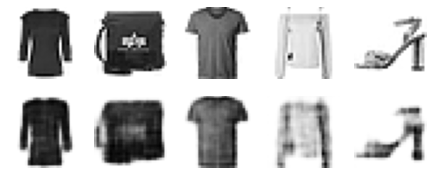

In [8]:
show_reconstructions(conv_ae)
plt.show()

In [9]:
keras.backend.clear_session()

In [10]:
np.random.seed(42)
tf.random.set_seed(42)

recurrent_encoder = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True, input_shape=[28, 28]),
    keras.layers.LSTM(30)
])

recurrent_decoder = keras.models.Sequential([
    keras.layers.RepeatVector(28, input_shape=[30]),
    keras.layers.LSTM(100, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(28, activation='sigmoid'))
])

recurrent_ae = keras.models.Sequential([recurrent_encoder, recurrent_decoder])
recurrent_ae.compile(loss='binary_crossentropy', 
                     optimizer=keras.optimizers.SGD(learning_rate=0.1), 
                     metrics=[rounded_accuracy])

In [11]:
history = recurrent_ae.fit(x_train, x_train, epochs=10, 
                           validation_data=(x_valid, x_valid))

Epoch 1/10
1719/1719 [==============================] - 27s 14ms/step - loss: 0.5019 - rounded_accuracy: 0.7689 - val_loss: 0.4505 - val_rounded_accuracy: 0.8224
Epoch 2/10
1719/1719 [==============================] - 19s 11ms/step - loss: 0.4008 - rounded_accuracy: 0.8440 - val_loss: 0.3758 - val_rounded_accuracy: 0.8625
Epoch 3/10
1719/1719 [==============================] - 18s 11ms/step - loss: 0.3677 - rounded_accuracy: 0.8672 - val_loss: 0.3616 - val_rounded_accuracy: 0.8726
Epoch 4/10
1719/1719 [==============================] - 19s 11ms/step - loss: 0.3531 - rounded_accuracy: 0.8779 - val_loss: 0.3593 - val_rounded_accuracy: 0.8731
Epoch 5/10
1719/1719 [==============================] - 18s 11ms/step - loss: 0.3430 - rounded_accuracy: 0.8858 - val_loss: 0.3392 - val_rounded_accuracy: 0.8894
Epoch 6/10
1719/1719 [==============================] - 17s 10ms/step - loss: 0.3355 - rounded_accuracy: 0.8910 - val_loss: 0.3324 - val_rounded_accuracy: 0.8942
Epoch 7/10
1719/1719 [======

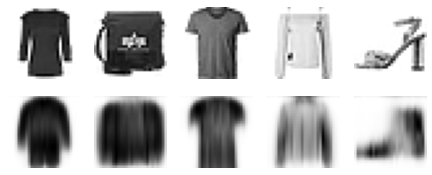

In [12]:
show_reconstructions(recurrent_ae)
plt.show()

In [13]:
keras.backend.clear_session()

In [14]:
np.random.seed(42)
tf.random.set_seed(42)

recurrent_encoder = keras.models.Sequential([
    keras.layers.SimpleRNN(100, return_sequences=True, input_shape=[28, 28]),
    keras.layers.SimpleRNN(30)
])

recurrent_decoder = keras.models.Sequential([
    keras.layers.RepeatVector(28, input_shape=[30]),
    keras.layers.SimpleRNN(100, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(28, activation='sigmoid'))
])

recurrent_ae = keras.models.Sequential([recurrent_encoder, recurrent_decoder])
recurrent_ae.compile(loss='binary_crossentropy', 
                     optimizer=keras.optimizers.SGD(learning_rate=0.1), 
                     metrics=[rounded_accuracy])

In [15]:
history = recurrent_ae.fit(x_train, x_train, epochs=10, 
                           validation_data=(x_valid, x_valid))

Epoch 1/10
1719/1719 [==============================] - 233s 135ms/step - loss: 0.4092 - rounded_accuracy: 0.8369 - val_loss: 0.3827 - val_rounded_accuracy: 0.8555
Epoch 2/10
1719/1719 [==============================] - 230s 134ms/step - loss: 0.3588 - rounded_accuracy: 0.8729 - val_loss: 0.3502 - val_rounded_accuracy: 0.8781
Epoch 3/10
1719/1719 [==============================] - 238s 139ms/step - loss: 0.3442 - rounded_accuracy: 0.8827 - val_loss: 0.3399 - val_rounded_accuracy: 0.8852
Epoch 4/10
1719/1719 [==============================] - 247s 143ms/step - loss: 0.3345 - rounded_accuracy: 0.8901 - val_loss: 0.3387 - val_rounded_accuracy: 0.8874
Epoch 5/10
1719/1719 [==============================] - 235s 137ms/step - loss: 0.3283 - rounded_accuracy: 0.8949 - val_loss: 0.3258 - val_rounded_accuracy: 0.8970
Epoch 6/10
1719/1719 [==============================] - 232s 135ms/step - loss: 0.3240 - rounded_accuracy: 0.8980 - val_loss: 0.3225 - val_rounded_accuracy: 0.9009
Epoch 7/10
1719/

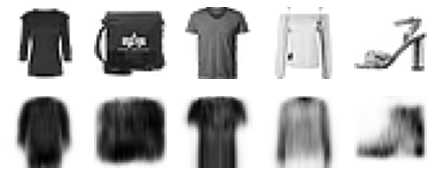

In [16]:
show_reconstructions(recurrent_ae)
plt.show()